In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### General Purpose

For dorsiflexors muscle, obtain the ankle angle  
$\theta_{perna} - \theta$  

### Lembretes  

Para comprimento do músculo+tendão, usar o polinômio de 4ª ordem em que entram os A's de um artigo lá

Tomar cuidado que há coisas na tabela que estão em graus mas nos cálculos usamos radianos  

*Rf* é mx no artigo que ele mencionou  
. $B_{x}$ retirar de uma tabela que tem no artigo  

$L_{ce} = L_{0}^{M}$  

$L_{slack} = L_{s}^{T} \cdot L_{0}^{M} $

  
$M = T_{M} - M_{G}$  

tal que $T_{M} = F_{M} \cdot R_{f}$

$R_{CM} = $  

$R_{f}(\theta)$ é um polinômio de 4ª ordem que no artigo é chamado de $m_{x}$


$\theta_{A}$ é o ângulo do tornozelo

$T_{A}$ é o torque resultante no tornozelo

### Classes and Functions

In [7]:
class Muscle:
    
    def __init__(self, Lslack, Lce_o, Fmax, alpha, dt):
        
        self.Lce_o   = Lce_o 
        self.Lslack  = Lslack        # slack length of SEE
        self.Fmax    = Fmax          # maximal isometric force
        self.alpha   = alpha   # penation angle
        self.UmaxTendon    = .04
        
        self.dt = dt
    
    def tendonLength(self, Lm, Lce_o, Lnorm_ce, alpha):
        '''
        Compute tendon length
        
        Inputs:
            Lm = 
            Lce_o = optimal length of the fiber
            Lnorm_ce = normalized contractile element length
        Output:
            Lnorm_see = normalized tendon length   
        '''
        
        Lnorm_see = Lm/self.Lce_o - Lnorm_ce*np.cos(self.alpha)
        
        return Lnorm_see
    
    
    def TendonForce (self, Lnorm_see, Lslack, Lce_o, UmaxTendon):
        '''
        Compute tendon force

        Inputs:
            Lnorm_see = normalized tendon length
            Lslack = slack length of the tendon (non-normalized)
            Lce_o = optimal length of the fiber
    
        Output:
            Fnorm_tendon = normalized tendon force
        
        '''
        if Lnorm_see < self.Lslack/self.Lce_o: 
            Fnorm_tendon = 0
        else: 
            Fnorm_tendon = ( (Lnorm_see - self.Lslack/self.Lce_o ) /
                              (UmaxTendon * self.Lslack/self.Lce_o ) )**2
        
        return Fnorm_tendon
    

    def ComputeTotalLenghtSize(self, theta, As):
        # theta = joint angle
        # As - coeficients for the polinomio

        auxAmultp = np.empty(As.shape);

        for i in range (len(As)):
            auxAmultp[i] = As[i] * (theta**i)

        Lm = sum(auxAmultp)

        return Lm

    def ParallelElementForce(self, Lnorm_ce):
        '''
        Compute parallel element force

        Inputs:
            Lnorm_ce = normalized contractile element length

        Output:
            Fnorm_kpe = normalized parallel element force

        '''
        Umax = 1

        if Lnorm_ce< 1: 
            Fnorm_kpe = 0
        else: 
            Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 

        return Fnorm_kpe

    
    def ForceLengthCurve(self, Lnorm_ce, width):

        F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])

        return F0

    
    def ContractileElementDot(self, F0, Fnorm_CE, a):

        '''
        Compute Contractile Element Derivative

        Inputs:
            F0 = Force-Length Curve
            Fce = Contractile element force

        Output:
            Lnorm_cedot = normalized contractile element length derivative

        '''

        FMlen = 1.4 # young adults
        Vmax = 10  # young adults
        Af = 0.25  #force-velocity shape factor

        Fnorm_CE = min(FMlen*a*F0 - 0.001, Fnorm_CE)

        if  Fnorm_CE > a*F0:

            b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_CE))/(FMlen-1)

        elif Fnorm_CE <= a*F0:

            b = a*F0 + Fnorm_CE/Af

        Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - a*F0)/b)

        return Lnorm_cedot

    def ContractileElementForce(self, Fnorm_tendon, Fnorm_kpe, alpha):
        '''
        Compute Contractile Element force

        Inputs:
            Fnorm_tendon = normalized tendon force
            Fnorm_kpe = normalized parallel element force

        Output:
            Fnorm_CE = normalized contractile element force
        '''
        Fnorm_CE = Fnorm_tendon/np.cos(alpha) - Fnorm_kpe
        return Fnorm_CE
    
    
    
    def updateMuscle(self, Lm, u Lnorm_ce, a)
        Lnorm_see = self.tendonLength(Lm, Lce_o, Lnorm_ce, alpha)
    
        # compute the force in the tendon
        Fnorm_tendon = self.TendonForce(Lnorm_see, Lslack, Lce_o, Umax)

        # compute the force in the parallel element
        Fnorm_kpe = self.ParallelElementForce (Lnorm_ce)     

        #isometric force at Lce from CE force length relationship
        F0 = self.ForceLengthCurve (Lnorm_ce, width)

        Fnorm_CE = self.ContractileElementForce(Fnorm_tendon, Fnorm_kpe, alpha) #Fnorm_CE = ~Fm

        #computing activation
        a = self.activation(a,u,h)

        #calculate CE velocity from Hill's equation    
        Lnorm_cedot = self.ContractileElementDot(F0, Fnorm_CE, a)
        
        Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
        
        return Fnorm_tendon, Lnorm_ce

    def activation(a, u, dt):
        '''
        Compute activation

        Inputs:
            u = idealized muscle excitation signal, 0 <= u <= 1
            a = muscular activation
            dt = time step

        Output:
            a = muscular activation  
        '''

        tau_deact = 50e-3 #young adults
        tau_act = 15e-3

        if u>a:
            tau_a = tau_act*(0.5+1.5*a)
        elif u <=a:
            tau_a = tau_deact/(0.5+1.5*a)

        #-------
        dadt = (u-a)/tau_a # euler

        a = a + dadt*dt
        #-------
        return a

In [3]:
class Skeleton:
    
    def __init__(self, M, I, Rf, Fnorm_tendon, Fmax, theta_jointSeg, theta_prox, m_distSeg, g, Rcm_distSeg):
        
        self.M     = M        # total moment in the joint
        self.I     = I        # inertia moment of the distal segment
        self.Rf    = Rf       # moment arm for the distal segment
        self.Fnorm_tendon  = Fnorm_tendon   # Normalized Force of the tendon
        self.Fmax  = Fmax     # maximum force of the muscle
        
        self.theta_jointSeg  = theta_jointSeg     # angle of the desired joint
        self.theta_proxSeg   = theta_proxSeg      # angle of the proximal segment
        self.m_distSeg       = m_distSeg          # maximal isometric force
        self.g   = 9.81    #    gravity acceleration
        self.Rcm_distSeg     = Rcm_distSeg        # CM of the distal segment        
    

### Functions

In [4]:
def computeMomentArmJoint(theta, Bs):
    # theta - joint angle
    # Bs - coeficients for the polinomio

    auxBmultp = np.empty(Bs.shape);
    for i in range (len(Bs)):
        auxBmultp[i] = Bs[i] * (theta**i)

    Rf = sum(auxBmultp)

    return Rf   

In [5]:
def ComputeAngularAcelerationJoint(M, I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        thetadd= angular aceleration of the joint
    '''
    thetadd = M/I
    return thetadd

In [6]:
def ComputeMomentJoint(Rf, Fnorm_tendon, Fmax, theta, theta_leg, m, g, Rcm):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    Tm = Rf*Fnorm_tendon*Fmax

    MG = m*g*Rcm*np.sin(theta_leg - theta)

    M = Tm - MG

    return M

### Foot caracteristics

In [8]:
Lfoot = 0.26 # [m]
m     = 75 # [kg]

mtable     = 0.0145
Rcmtable   = 0.5
Rgirotable = 0.69

mfoot      = mtable * m

Rcmfoot    = Rcmtable * Lfoot

Rgirofoot  = Rgirotable * Lfoot
Ifoot      = mfoot * (Rgirofoot**2)


Rcm  = Rcmfoot
I    = Ifoot

### Muscle Properties

In [9]:
Lce_o   = .090        
Lslack  = 2.4 * Lce_o   #  sack length of SEE
Fmax    = 1400          # maximal isometric force for dorsiflexors
alpha   = 7*np.pi/180   # penation angle

In [10]:
Umax    = .04         #  SEE strain at Fmax
width   = .63         #  *Lce_o

In [11]:
a  = 1 #inital conditional for ativation
u  = 1 #Initial conditional for Brain's activation

#b = .25*10#*Lce_o

In [12]:
# Coefs for total muscle+tendon length

As = np.array([30.6, -7.44e-2, -1.41e-4, 2.42e-6, 1.5e-8]) / 100   # at [m] instead of [cm]


# Coefs for moment arm for ankle angle

Bs = np.array([4.3, 1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8]) / 100  # at [m] instead of [cm]


In [13]:
g = 9.81# acceleration of gravity

In [14]:
Bs

array([ 4.30e-02,  1.66e-04, -3.89e-06, -4.45e-08, -4.34e-10])

### Initial conditions

In [15]:
theta = 0  # start as 0 degree of flexion

thetad = 0 # zero velocity

theta_leg = np.pi/2; # the leg angle in relation to the ground

Lm0 = 0.306 #initial total lenght of the muscle  -- isso é o TA de um dos artigos que eles mostraram
Lm = 0.31 #initial total lenght of the muscle

Lnorm_ce = ((Lm0 - Lslack)/np.cos(alpha))/Lce_o #norm

t0 = 0 #Initial time
tf = 1 #Final Time

h = 5e-4 #integration step size and step counter

### Initialize arrays

In [16]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
thetavec=np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
FiberVelocity = np.empty(t.shape)

### Atribute classes

In [17]:
dorsiflexor = Muscle(Lslack, Lce_o, Fmax, alpha)
dorsiflexor.Lce_o

# soleos = Muscle(Lslack, Lce_o, Fmax, alpha)
# soleos.Lce_o

0.09

## Simulation

In [18]:
# Tenho de colocar a classe numa "palavra


for i in range (len(t)):
    
    # Compute tendo+muscle length
    Lm =  dorsiflexor.ComputeTotalLenghtSize(theta*180/math.pi, As)
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compute the tendon length
    Lnorm_see = dorsiflexor.tendonLength(Lm, Lce_o, Lnorm_ce, alpha)
    
    # compute the force in the tendon
    Fnorm_tendon = dorsiflexor.TendonForce(Lnorm_see, Lslack, Lce_o, Umax)
    
    # compute the force in the parallel element
    Fnorm_kpe = dorsiflexor.ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = dorsiflexor.ForceLengthCurve (Lnorm_ce, width)
    
    Fnorm_CE = dorsiflexor.ContractileElementForce(Fnorm_tendon, Fnorm_kpe, alpha) #Fnorm_CE = ~Fm
    
    #computing activation
    a = activation(a,u,h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = dorsiflexor.ContractileElementDot(F0, Fnorm_CE, a)
    
    
    
    #Compute MomentJoint
    Rf = computeMomentArmJoint(theta*180/math.pi, Bs) 
    M  = ComputeMomentJoint(Rf, Fnorm_tendon, Fmax, theta, theta_leg, mfoot, g, Rcmfoot)
       
    
    # Euler integration steps
    Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
    
    #Compute Angular Aceleration Joint
    thetadd = ComputeAngularAcelerationJoint(M,I)
    thetad = thetad + h*thetadd
    theta  = theta  + h*thetad


    # # STORE variables in vectors
    F[i] = Fnorm_tendon * Fmax
    
    Fkpe[i] = Fnorm_kpe * Fmax
    
    FiberLen[i] = Lnorm_ce * Lce_o
    
    TendonLen[i] = Lnorm_see*Lce_o
    
    a_dynamics[i] = a
    
    thetavec[i] = theta
    
    FiberVelocity[i] = Lnorm_cedot * Lce_o
    

Text(0,0.5,'a-values during the simulation')

<Figure size 432x288 with 0 Axes>

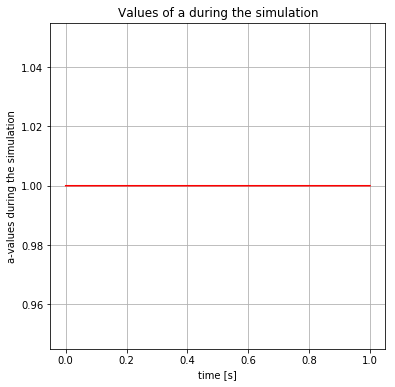

In [19]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize = (6,6),sharex=True)

ax.plot(t,a_dynamics,c='red')
ax.set_title('Values of a during the simulation')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('a-values during the simulation')

Text(0,0.5,'Force (N)')

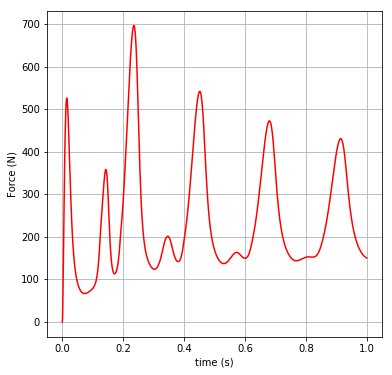

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')

Text(0,0.5,'Ankle Joint Angle (°)')

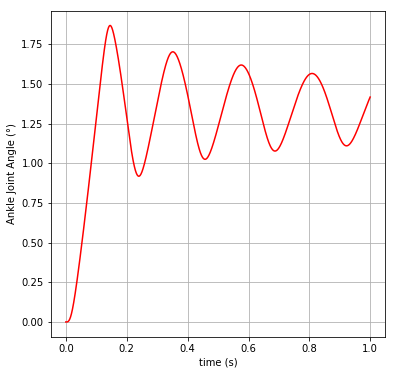

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,thetavec,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Ankle Joint Angle (°)')

Text(0,0.5,'Velocity of fiber')

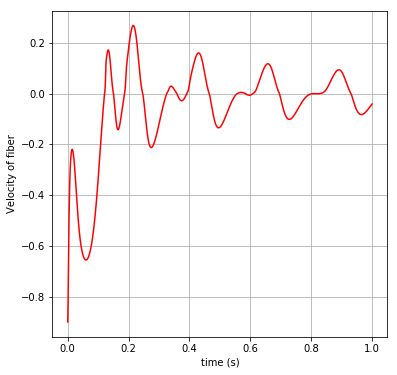

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberVelocity,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Velocity of fiber')

Text(0,0.5,'Length [m]')

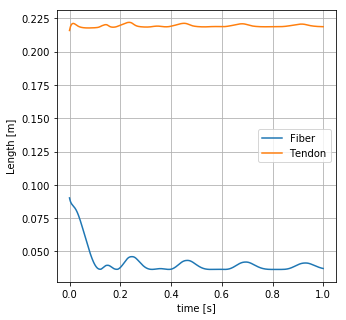

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5,5),sharex=True)

ax.plot(t, FiberLen, label = 'Fiber')
ax.plot(t, TendonLen, label = 'Tendon')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Length [m]')